# Praca domowa 2

In [115]:
import numpy as np
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.datasets import load_diabetes,fetch_california_housing
from sklearn.model_selection import GridSearchCV, train_test_split
import time
import pandas as pd

## Implementacja algorytmu AdaBoost

In [116]:
def adaboost(X,y,B=10,learning_rate=1.0, max_depth=10):
    n = X.shape[0]
    w = np.ones(n)/n
    eps= [0]*B
    komitet=[]
    beta =[0]*B
    
    for k in range(B):
        f_k = tree.DecisionTreeRegressor(max_depth = max_depth)
        f_k.fit(X,y,sample_weight = w)
        y_pred = f_k.predict(X)
        r=np.abs(y_pred-y)
        r = r/max(r)
        
        for i in range(n):
            eps[k]= eps[k]+w[i]*r[i]
        if eps[k]>=0.5:
            break
            
        beta[k]= eps[k]/(1-eps[k])
        komitet.append((f_k, beta[k]))
        w = w * (beta[k] ** (1 - r))
        w = w / np.sum(w)
        
    return komitet

            
def predict_adaboost(komitet, X):
    B = len(komitet)
    preds = np.zeros((B, X.shape[0]))
    betas = np.zeros(B)
    
    for k, (model, beta_k) in enumerate(komitet):
        preds[k] = model.predict(X)
        betas[k] = beta_k
    
    log_betas = np.log(1 / (betas)) 
    final_preds = np.average(preds, axis=0, weights=log_betas)
    
    return np.array(final_preds)

from sklearn.base import BaseEstimator, RegressorMixin

class AdaBoostCustom(BaseEstimator, RegressorMixin):
    def __init__(self, B=10, learning_rate=1.0, max_depth=10):
        self.B = B
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.komitet = None
    
    def fit(self, X, y):
        self.komitet = adaboost(X, y, B=self.B, learning_rate=self.learning_rate, max_depth=self.max_depth)
        return self
    
    def predict(self, X):
        return predict_adaboost(self.komitet, X)

## Implementacja algorytmu GradientBoost

In [120]:
class MyGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.models = []
        self.initial_prediction = None

    def fit(self, X, y):
        self.initial_prediction = np.mean(y)
        y_pred = np.full_like(y, self.initial_prediction, dtype=np.float64)

        for _ in range(self.n_estimators):
            residuals = y - y_pred

            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X, residuals)

            update = tree.predict(X)

            y_pred += self.learning_rate * update

            self.models.append(tree)

    def predict(self, X):
        y_pred = np.full((X.shape[0],), self.initial_prediction, dtype=np.float64)
        for tree in self.models:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred



## Wybór zbiorów danych

In [203]:
#mały zbiór
diabetes = load_diabetes()
X_1, y_1 = diabetes.data, diabetes.target

#średni zbiór 
california = fetch_california_housing()
X_2, y_2 = california.data, california.target

#duży zbiór
X_3, y_3 = make_regression(n_samples=10000, n_features=100, noise=0.1, random_state=42)

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

## Eksperymentalna analiza

In [118]:
#Przestrzeń parametrów
B_values = [10, 50, 100]
learning_rates = [0.1, 0.5, 1.0]
max_depths = [3, 5, 10]

In [129]:
results_a1 = []

for B in B_values:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
            model = AdaBoostCustom(B=B, learning_rate=learning_rate, max_depth=max_depth)
            
            start_time = time.time()
            model.fit(X_1_train, y_1_train)
            training_time = time.time() - start_time
            

            predictions = model.predict(X_1_test)
            
            
            mse = mean_squared_error(y_1_test, predictions)
            
           
            results_a1.append({
                'B': B,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'training_time': training_time
            })

results_df_a1 = pd.DataFrame(results_a1)
print("Tabela wyników:")
print(results_df_a1)

Tabela wyników:
      B  learning_rate  max_depth          mse  training_time
0    10            0.1          3  2955.936278       0.010962
1    10            0.1          5  2952.308042       0.080271
2    10            0.1         10  3418.405560       0.120207
3    10            0.5          3  2955.936278       0.048126
4    10            0.5          5  2967.624053       0.090321
5    10            0.5         10  3483.783725       0.110029
6    10            1.0          3  2955.936278       0.054588
7    10            1.0          5  2885.771102       0.074229
8    10            1.0         10  3539.909046       0.096569
9    50            0.1          3  2921.963895       0.101235
10   50            0.1          5  2884.055043       0.333585
11   50            0.1         10  3473.909649       0.547840
12   50            0.5          3  2921.963895       0.095227
13   50            0.5          5  2883.437390       0.340147
14   50            0.5         10  3569.145496       0

In [135]:
results_a2 = []

for B in B_values:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
        
            model = AdaBoostCustom(B=B, learning_rate=learning_rate, max_depth=max_depth)
            
            start_time = time.time()
            model.fit(X_2_train, y_2_train)
            training_time = time.time() - start_time
            
            predictions = model.predict(X_2_test)
            mse = mean_squared_error(y_2_test, predictions)
            
            results_a2.append({
                'B': B,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'training_time': training_time
            })

results_df_a2 = pd.DataFrame(results_a2)
print("Tabela wyników:")
print(results_df_a2)


Tabela wyników:
      B  learning_rate  max_depth       mse  training_time
0    10            0.1          3  0.628411       1.387963
1    10            0.1          5  0.476236       2.311157
2    10            0.1         10  0.283035       4.438309
3    10            0.5          3  0.628344       1.534194
4    10            0.5          5  0.476236       2.280428
5    10            0.5         10  0.283363       4.211909
6    10            1.0          3  0.628411       1.419463
7    10            1.0          5  0.476254       2.262048
8    10            1.0         10  0.283971       4.217754
9    50            0.1          3  0.708131       2.698230
10   50            0.1          5  0.660673       9.843393
11   50            0.1         10  0.289482      20.681144
12   50            0.5          3  0.708131       2.683399
13   50            0.5          5  0.660564       9.509572
14   50            0.5         10  0.289460      20.315736
15   50            1.0          3  0.708

In [119]:
results_a3 = []

for B in B_values:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
        
            model = AdaBoostCustom(B=B, learning_rate=learning_rate, max_depth=max_depth)
            
            start_time = time.time()
            model.fit(X_3_train, y_3_train)
            training_time = time.time() - start_time
            
            predictions = model.predict(X_3_test)
            mse = mean_squared_error(y_3_test, predictions)
            
            results_a3.append({
                'B': B,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'training_time': training_time
            })

results_df_a3 = pd.DataFrame(results_a3)
print("Tabela wyników:")
print(results_df_a3)


Tabela wyników:
      B  learning_rate  max_depth           mse  training_time
0    10            0.1          3  14461.240233      10.196915
1    10            0.1          5  10169.553005      16.867920
2    10            0.1         10   7049.001486      29.983458
3    10            0.5          3  14461.240233      10.646771
4    10            0.5          5  10169.553005      16.111800
5    10            0.5         10   7018.655305      30.000746
6    10            1.0          3  14461.240233      10.955581
7    10            1.0          5  10169.553005      16.787358
8    10            1.0         10   7054.132852      30.337870
9    50            0.1          3   8727.692033      52.675316
10   50            0.1          5   6502.627478      83.685546
11   50            0.1         10   6119.886718     150.083151
12   50            0.5          3   8727.692033      52.530725
13   50            0.5          5   6501.971519      85.725250
14   50            0.5         10   610

In [187]:
index_to_fix = 23 #outlier spowodowany uśpieniem komputera - zbyt duży czas wykonywania
row_to_fix = results_df_a3.loc[index_to_fix].copy()
df_without_outlier = results_df_a3.drop(index=index_to_fix)
average_training_time_B100 = df_without_outlier[df_without_outlier['B'] == 100]['training_time'].mean()
row_to_fix['training_time'] = average_training_time_B100
results_df_a3.loc[index_to_fix] = row_to_fix

      B  learning_rate  max_depth           mse  training_time
0    10            0.1          3  21264.866426       9.581510
1    10            0.1          5  16245.315358      14.949194
2    10            0.1         10  12038.928033      26.078557
3    10            0.5          3   6412.466964       9.057922
4    10            0.5          5   4664.861591      15.437695
5    10            0.5         10   7406.504967      27.615876
6    10            1.0          3   5560.270385       9.511885
7    10            1.0          5   6465.492832      15.407101
8    10            1.0         10  15948.907081      29.596857
9    50            0.1          3   5953.507144      48.771553
10   50            0.1          5   3299.794603      77.584175
11   50            0.1         10   4938.302094     134.773139
12   50            0.5          3   1926.981194      50.079184
13   50            0.5          5   3042.904490      79.135619
14   50            0.5         10   7261.603605     154

In [186]:
index_to_fix = 25
row_to_fix = results_df_g3.loc[index_to_fix].copy()
df_without_outlier = results_df_g3.drop(index=index_to_fix)
average_training_time_B100 = df_without_outlier[df_without_outlier['B'] == 100]['training_time'].mean()
row_to_fix['training_time'] = average_training_time_B100
results_df_g3.loc[index_to_fix] = row_to_fix
print(results_df_g3)

      B  learning_rate  max_depth           mse  training_time
0    10            0.1          3  21264.866426       9.581510
1    10            0.1          5  16245.315358      14.949194
2    10            0.1         10  12038.928033      26.078557
3    10            0.5          3   6412.466964       9.057922
4    10            0.5          5   4664.861591      15.437695
5    10            0.5         10   7406.504967      27.615876
6    10            1.0          3   5560.270385       9.511885
7    10            1.0          5   6465.492832      15.407101
8    10            1.0         10  15948.907081      29.596857
9    50            0.1          3   5953.507144      48.771553
10   50            0.1          5   3299.794603      77.584175
11   50            0.1         10   4938.302094     134.773139
12   50            0.5          3   1926.981194      50.079184
13   50            0.5          5   3042.904490      79.135619
14   50            0.5         10   7261.603605     154

In [123]:
results_g1 = []

for B in B_values:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
            model = MyGradientBoostingRegressor(
                n_estimators=B,
                learning_rate=learning_rate,
                max_depth=max_depth
            )

            
            start_time = time.time()
            model.fit(X_1_train, y_1_train)
            training_time = time.time() - start_time

            predictions = model.predict(X_1_test)

            mse = mean_squared_error(y_1_test, predictions)

            results_g1.append({
                'B': B,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'training_time': training_time
            })

results_df_g1 = pd.DataFrame(results_g1)
print("Tabela wyników (Diabetes dataset):")
print(results_df_g1)

Tabela wyników (Diabetes dataset):
      B  learning_rate  max_depth          mse  training_time
0    10            0.1          3  3219.370146       0.033468
1    10            0.1          5  3263.993033       0.046834
2    10            0.1         10  3425.521485       0.108407
3    10            0.5          3  3512.355264       0.035952
4    10            0.5          5  3589.354030       0.047191
5    10            0.5         10  3987.291699       0.097169
6    10            1.0          3  4544.002776       0.037520
7    10            1.0          5  5474.352468       0.041408
8    10            1.0         10  5220.939694       0.094982
9    50            0.1          3  2853.858269       0.196151
10   50            0.1          5  3275.768151       0.262254
11   50            0.1         10  3820.177483       0.480415
12   50            0.5          3  4441.595357       0.199263
13   50            0.5          5  3832.528699       0.246477
14   50            0.5         10  

In [126]:
results_g2 = []

for B in B_values:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
            model = MyGradientBoostingRegressor(
                n_estimators=B,
                learning_rate=learning_rate,
                max_depth=max_depth
            )

            
            start_time = time.time()
            model.fit(X_2_train, y_2_train)
            training_time = time.time() - start_time

            predictions = model.predict(X_2_test)

            mse = mean_squared_error(y_2_test, predictions)

            results_g2.append({
                'B': B,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'training_time': training_time
            })

results_df_g2 = pd.DataFrame(results_g2)
print("Tabela wyników (Diabetes dataset):")
print(results_df_g2)

Tabela wyników (Diabetes dataset):
      B  learning_rate  max_depth       mse  training_time
0    10            0.1          3  0.653306       1.129718
1    10            0.1          5  0.542237       1.843428
2    10            0.1         10  0.419196       3.504819
3    10            0.5          3  0.348502       1.123255
4    10            0.5          5  0.297814       1.809481
5    10            0.5         10  0.287733       3.619386
6    10            1.0          3  0.341891       1.166726
7    10            1.0          5  0.323036       1.916549
8    10            1.0         10  0.473313       3.984292
9    50            0.1          3  0.336161       6.151778
10   50            0.1          5  0.274961       9.590100
11   50            0.1         10  0.235600      19.007662
12   50            0.5          3  0.267216       5.823444
13   50            0.5          5  0.248192       9.273952
14   50            0.5         10  0.291188      19.822245
15   50            1.

In [180]:
results_g3 = []

for B in B_values:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
            model = MyGradientBoostingRegressor(
                n_estimators=B,
                learning_rate=learning_rate,
                max_depth=max_depth
            )

            
            start_time = time.time()
            model.fit(X_3_train, y_3_train)
            training_time = time.time() - start_time

            predictions = model.predict(X_3_test)

            mse = mean_squared_error(y_3_test, predictions)

            results_g3.append({
                'B': B,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'training_time': training_time
            })

results_df_g3 = pd.DataFrame(results_g3)
print("Tabela wyników (Diabetes dataset):")
print(results_df_g3)

Tabela wyników (Diabetes dataset):
      B  learning_rate  max_depth           mse  training_time
0    10            0.1          3  21264.866426       9.581510
1    10            0.1          5  16245.315358      14.949194
2    10            0.1         10  12038.928033      26.078557
3    10            0.5          3   6412.466964       9.057922
4    10            0.5          5   4664.861591      15.437695
5    10            0.5         10   7406.504967      27.615876
6    10            1.0          3   5560.270385       9.511885
7    10            1.0          5   6465.492832      15.407101
8    10            1.0         10  15948.907081      29.596857
9    50            0.1          3   5953.507144      48.771553
10   50            0.1          5   3299.794603      77.584175
11   50            0.1         10   4938.302094     134.773139
12   50            0.5          3   1926.981194      50.079184
13   50            0.5          5   3042.904490      79.135619
14   50            0

### Grupowanie danych

In [188]:
average_mse_a1 = results_df_a1.groupby('learning_rate')['mse'].mean().reset_index()
average_mse_a2= results_df_a2.groupby('learning_rate')['mse'].mean().reset_index()
average_mse_a3 = results_df_a3.groupby('learning_rate')['mse'].mean().reset_index()
average_mse_g1= results_df_g1.groupby('learning_rate')['mse'].mean().reset_index()
average_mse_g2 = results_df_g2.groupby('learning_rate')['mse'].mean().reset_index()
average_mse_g3 = results_df_g3.groupby('learning_rate')['mse'].mean().reset_index()

average_times_a1 = results_df_a1.groupby('B')['training_time'].mean()
average_times_g1 = results_df_g1.groupby('B')['training_time'].mean()
average_times_a2 = results_df_a2.groupby('B')['training_time'].mean()
average_times_g2 = results_df_g2.groupby('B')['training_time'].mean()
average_times_a3 = results_df_a3.groupby('B')['training_time'].mean()
average_times_g3 = results_df_g3.groupby('B')['training_time'].mean()

markdown_table_a1 = average_mse_a1.to_markdown(index=False)
markdown_table_a2 = average_mse_a2.to_markdown(index=False)
markdown_table_a3 = average_mse_a3.to_markdown(index=False)

markdown_table_g1 = average_mse_g1.to_markdown(index=False)
markdown_table_g2 = average_mse_g2.to_markdown(index=False)
markdown_table_g3 = average_mse_g3.to_markdown(index=False)

In [197]:
a1 = results_df_a1.loc[results_df_a1['mse'].idxmin()]
a2 = results_df_a2.loc[results_df_a2['mse'].idxmin()]
a3 = results_df_a3.loc[results_df_a3['mse'].idxmin()]

g1 = results_df_g1.loc[results_df_g1['mse'].idxmin()]
g2 = results_df_g2.loc[results_df_g2['mse'].idxmin()]
g3 = results_df_g3.loc[results_df_g3['mse'].idxmin()]

best_results = [
    {'source': 'AdaBoost - Zbiór 1', **a1.to_dict()},
    {'source': 'AdaBoost - Zbiór 2', **a2.to_dict()},
    {'source': 'AdaBoost - Zbiór 3', **a3.to_dict()},
    {'source': 'GradientBoost - Zbiór 1', **g1.to_dict()},
    {'source': 'GradientBoost - Zbiór 2', **g2.to_dict()},
    {'source': 'GradientBoost - Zbiór 3', **g3.to_dict()},
]

best_results_df = pd.DataFrame(best_results)
columns_to_show = ['source', 'B', 'learning_rate', 'max_depth']
best_results_selected = best_results_df[columns_to_show]


Najlepsze modele (bez MSE, czasu i rozmiaru danych):
                    source      B  learning_rate  max_depth
0       AdaBoost - Zbiór 1   50.0            1.0        5.0
1       AdaBoost - Zbiór 2   10.0            0.1       10.0
2       AdaBoost - Zbiór 3  100.0            0.5        5.0
3  GradientBoost - Zbiór 1   50.0            0.1        3.0
4  GradientBoost - Zbiór 2  100.0            0.1       10.0
5  GradientBoost - Zbiór 3  100.0            0.1        5.0


## Porównanie dwóch modeli 

###  MSE dla różnych learning rate - Adaboost

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; padding: 10px; text-align: center;">
    <strong>Najmniejszy zbiór danych</strong>
    <table>
        <tr>
            <th>learning_rate</th>
            <th>mse</th>
        </tr>
        <tr>
            <td>0.1</td>
            <td>3078.9</td>
        </tr>
        <tr>
            <td>0.5</td>
            <td>3099.18</td>
        </tr>
        <tr>
            <td>1</td>
            <td>3087.57</td>
        </tr>
    </table>
</div>

<div style="width: 30%; padding: 10px; text-align: center;">
    <strong>Średni zbiór danych</strong>
    <table>
        <tr>
            <th>learning_rate</th>
            <th>mse</th>
        </tr>
        <tr>
            <td>0.1</td>
            <td>0.523927</td>
        </tr>
        <tr>
            <td>0.5</td>
            <td>0.523943</td>
        </tr>
        <tr>
            <td>1</td>
            <td>0.524096</td>
        </tr>
    </table>
</div>

<div style="width: 30%; padding: 10px; text-align: center;">
    <strong>Największy zbiór danych</strong>
    <table>
        <tr>
            <th>learning_rate</th>
            <th>mse</th>
        </tr>
        <tr>
            <td>0.1</td>
            <td>8973.28</td>
        </tr>
            <tr>
            <td>0.5</td>
            <td>6369.28</td>
        </tr>
        <tr>
            <td>1</td>
            <td>5933.78</td>
        </tr>
    </table>
</div>

</div>


### MSE dla różnych learning rate - GradientBoost

<div style="display: flex; justify-content: space-around;">

<div style="width: 45%; padding: 10px; text-align: center;">
    <strong>Najmniejszy zbiór danych</strong>
    <table>
        <tr>
            <th>learning_rate</th>
            <th>mse</th>
        </tr>
        <tr>
            <td>0.1</td>
            <td>3336.96</td>
        </tr>
        <tr>
            <td>0.5</td>
            <td>4003.19</td>
        </tr>
        <tr>
            <td>1</td>
            <td>5799.77</td>
        </tr>
    </table>
</div>

<div style="width: 45%; padding: 10px; text-align: center;">
    <strong>Średni zbiór danych</strong>
    <table>
        <tr>
            <th>learning_rate</th>
            <th>mse</th>
        </tr>
        <tr>
            <td>0.1</td>
            <td>0.358663</td>
        </tr>
        <tr>
            <td>0.5</td>
            <td>0.280075</td>
        </tr>
        <tr>
            <td>1</td>
            <td>0.374576</td>
        </tr>
    </table>
</div>

<div style="width: 45%; padding: 10px; text-align: center;">
    <strong>Największy zbiór danych</strong>
    <table>
        <tr>
            <th>learning_rate</th>
            <th>mse</th>
        </tr>
        <tr>
            <td>0.1</td>
            <td>8003.90</td>
        </tr>
        <tr>
            <td>0.5</td>
            <td>4742.41</td>
        </tr>
        <tr>
            <td>1</td>
            <td>9182.29</td>
        </tr>
    </table>
</div>
    
</div>


### Najlepsze modele dla każdego zbioru

| Source                   |   B  |   Learning Rate |   Max Depth |
|:--------------------------|-----:|----------------:|------------:|
| AdaBoost - Zbiór 1        |  50  |             1.0 |           5 |
| AdaBoost - Zbiór 2        |  10  |             0.1 |          10 |
| AdaBoost - Zbiór 3        | 100  |             0.5 |           5 |
| GradientBoost - Zbiór 1   |  50  |             0.1 |           3 |
| GradientBoost - Zbiór 2   | 100  |             0.1 |          10 |
| GradientBoost - Zbiór 3   | 100  |             0.1 |           5 |



### Wydajność czasowa modeli, a liczba drzew

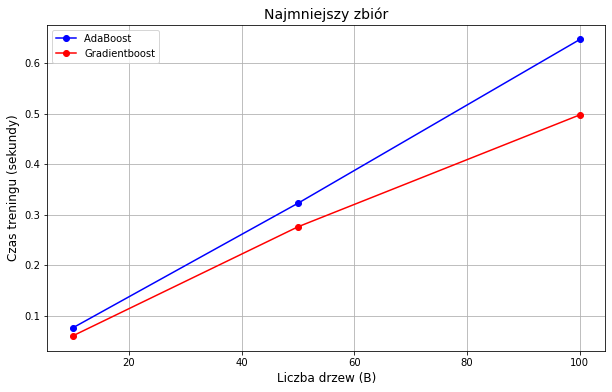

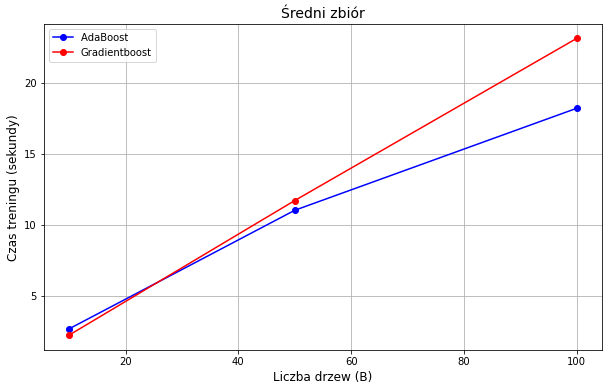

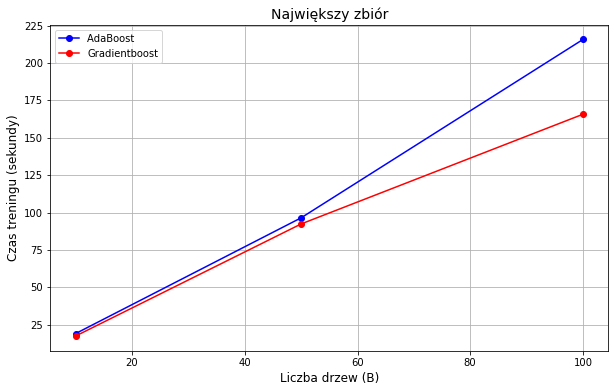

In [201]:
plt.figure(figsize=(10, 6))
plt.plot(average_times_a1.index, average_times_a1.values, marker='o', linestyle='-', color='b', label='AdaBoost ')
plt.plot(average_times_g1.index, average_times_g1.values, marker='o', linestyle='-', color='r', label='Gradientboost')
plt.title('Najmniejszy zbiór', fontsize=14)
plt.xlabel('Liczba drzew (B)', fontsize=12)
plt.ylabel('Czas treningu (sekundy)', fontsize=12)
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(average_times_a2.index, average_times_a2.values, marker='o', linestyle='-', color='b', label='AdaBoost ')
plt.plot(average_times_g2.index, average_times_g2.values, marker='o', linestyle='-', color='r', label='Gradientboost')
plt.title('Średni zbiór', fontsize=14)
plt.xlabel('Liczba drzew (B)', fontsize=12)
plt.ylabel('Czas treningu (sekundy)', fontsize=12)
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(average_times_a3.index, average_times_a3.values, marker='o', linestyle='-', color='b', label='AdaBoost ')
plt.plot(average_times_g3.index, average_times_g3.values, marker='o', linestyle='-', color='r', label='Gradientboost')
plt.title('Największy zbiór', fontsize=14)
plt.xlabel('Liczba drzew (B)', fontsize=12)
plt.ylabel('Czas treningu (sekundy)', fontsize=12)
plt.legend()
plt.grid(True)

![](a3g3.png)

### Wpływ głębokości drzewa na jakość predykcji 

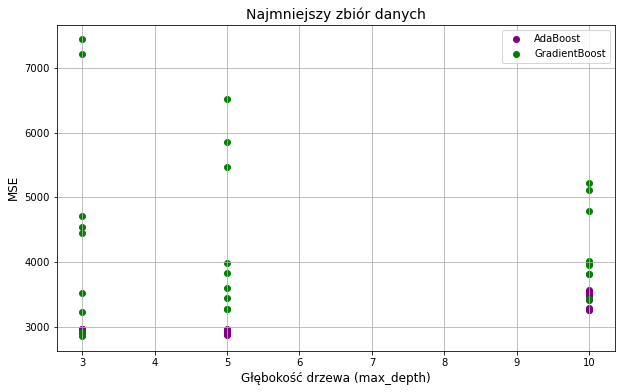

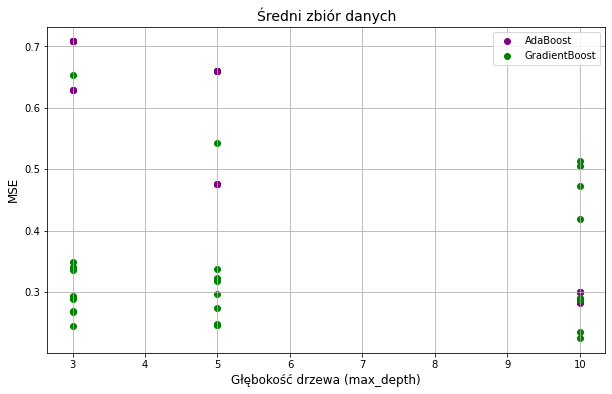

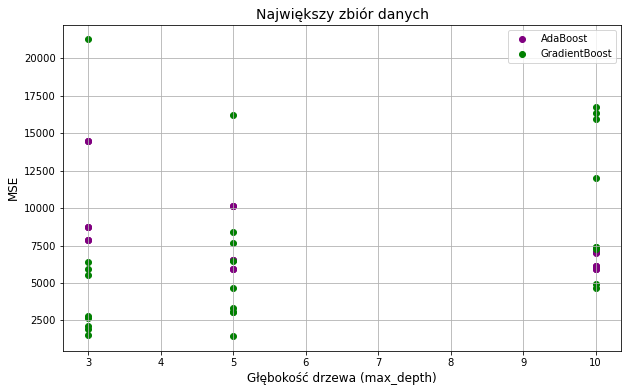

In [202]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df_a1['max_depth'], results_df_a1['mse'], color='purple', alpha=1, label='AdaBoost')
plt.scatter(results_df_g1['max_depth'], results_df_g1['mse'], color='green', alpha=1, label='GradientBoost')
plt.title('Najmniejszy zbiór danych', fontsize=14)
plt.xlabel('Głębokość drzewa (max_depth)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('plota1g1d.png') 

plt.figure(figsize=(10, 6))
plt.scatter(results_df_a2['max_depth'], results_df_a2['mse'], color='purple', alpha=1, label='AdaBoost')
plt.scatter(results_df_g2['max_depth'], results_df_g2['mse'], color='green', alpha=1, label='GradientBoost')
plt.title('Średni zbiór danych', fontsize=14)
plt.xlabel('Głębokość drzewa (max_depth)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('plota2g2d.png') 

plt.figure(figsize=(10, 6))
plt.scatter(results_df_a3['max_depth'], results_df_a3['mse'], color='purple', alpha=1, label='AdaBoost')
plt.scatter(results_df_g3['max_depth'], results_df_g3['mse'], color='green', alpha=1, label='GradientBoost')
plt.title('Największy zbiór danych', fontsize=14)
plt.xlabel('Głębokość drzewa (max_depth)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('plota3g3d.png')

## Wnioski 

#### Learning_rate 
1. W przypadku AdaBoost learning rate nie ma znaczącego wpływu dla mniejszego i średniego zbioru danych. W największym zbiorze danych możemy zaobserwować, że MSE maleje wraz ze zwiększaniem learning rate. Obserwacja, że wyższy learning rate prowadzi do zmniejszenia MSE, sugeruje, że model szybciej koncentruje się na trudniejszych przypadkach i efektywnie poprawia swoje predykcje.
2. Dla modelu GradientBoost dla każdych danych w ogólności wzrost learning rate wiąże się ze wzrostem MSE. Wskazuje to na potencjalne przeuczenie modelu. Wyższy learning rate sprawia, że każde kolejne drzewo w modelu wnosi większy wkład w predykcję, przez co model może się przeuczać
3. Dla największego zbioru danych i modelu GradientBoost mamy znaczny spadek MSE dla learning rate 0.5, a następnie wzrost dla 1. Sugeruję to istnienie optymalnego poziomu learning rate, w którym nie będziemy przeuczać modelu.
4. Gradient boost daje w ogólności niższe średnie wyniki MSE - wyjątkiem jest najmniejszy zbiór, zatem AdaBoost może być bardziej skuteczny w przypadku danych o niewielkim rozmiarze
5. W każdym przypadku dla Gradient Boosta najlpeszy model miał learning rate 0.1, ale za to dużą ilość drzew. Możemy próbować wysnuć wnioski, że małe learning rate jest skuteczne, ale wiąże się to ze zwiększaniem liczby drzew w komitecie


#### Liczba drzew
1. Wraz ze wzrostem liczby drzew rośnie czas trenowania modelu.
2. Im mniejszy zbiór danych tym modele szybciej się uczą.
3. Dla mniejszego i największego zbioru danych wydajniejszym modelem okazał się Gradient Booster.
4. Najlepsze modele (o najniższym MSE) są zazwyczaj dla większej liczby drzew w komitecie. Jest to dość intuicyjne, ponieważ im więcej drzew głosuję, tym mniej powinny się mylić


#### Maksymalna głębokość drzewa (max_depth)
1. Dla najmniejszego zbioru i AdaBoost MSE znacząco wzrósł, gdy zwiększyliśmy maksymalną głebokość drzewa do 10. Może to sugerować przeuczanie się modelu. GradientBoost charakteryzuję się większym rozrzutem niż AdaBoost. Obserwację bez znaczących outlierów są dla najgłebszych drzew. Obserwujemy wysokie MSE, dla kilku przypadków, gdy głębokość drzewa jest równa 3. AdaBoost dla najmnijeszego zbioru wydaję się wypadać lepiej
2. Dla średniego zbioru i AdabBoost widzimy poprawę wraz, ze zwiększaniem głębokości drzewa. Zwiększająca się głębokość drzewa może pozwalać modelowi AdaBoost na lepsze uchwycenie złożoności danych. Dla GradientBoosta i głębokości 10 obserwujemy punkty o większym MSE, co oznacza, że model w niektórych przypadkach może się przeuczać. 
3. GradientBoost działa lepiej dla mnijeszej głębokości drzewa w przypadku największego zbioru danych. Dla AdaBoost nie zauważalna jest konkretna tendecja, oprócz tego, że dla mało głębokich drzewwk dizała słabiej. Dla najwięszego zbioru danych GradientBoost ma przewagę nad AdaBoost
4. Najlepsze modele są dla komitetów o głębokości drzewa 5 lub 10. Mała głębokość drzewa może prowadzić do zbyt prostego modelu, który nie jest w stanie uchwycić złożonych wzorców w danych 